# DSE Dissertation

## Topic Analysis

#### Load Packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sn
from wordcloud import WordCloud

#### Load Dataset

In [3]:
"""

Loading dataset

"""

class UtteranceExample:
    def __init__(self, text, label, do_lower_case):
        self.original_text = text
        self.text = text
        self.label = label

        if do_lower_case:
            self.text = self.text.lower()

    def to_dict(self):
      return {
          'utterance': self.original_text,
          'intent': self.label,
      }
        
def load_utterance_examples(file_path, do_lower_case=True):
    examples = []

    with open('{}/seq.in'.format(file_path), 'r', encoding="utf-8") as f_text, open('{}/label'.format(file_path), 'r', encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            e = UtteranceExample(text.strip(), label.strip(), do_lower_case)
            examples.append(e)

    return examples



In [4]:
data = load_utterance_examples("/content/sample_data")

utterances= pd.DataFrame.from_records([d.to_dict() for d in data])

print(utterances)

                                              utterance           intent
0                        i am still waiting on my card?     card_arrival
1     what can i do if my card still hasn't arrived ...     card_arrival
2     i have been waiting over a week. is the card s...     card_arrival
3     can i track my card while it is in the process...     card_arrival
4     how do i know if i will get my card, or if it ...     card_arrival
...                                                 ...              ...
8617             you provide support in what countries?  country_support
8618                 what countries are you supporting?  country_support
8619                what countries are getting support?  country_support
8620                     are cards available in the eu?  country_support
8621                   which countries are represented?  country_support

[8622 rows x 2 columns]


### Exploratory Data Analysis

In [5]:
utterances.shape

(8622, 2)

In [6]:
utterances.dropna(axis=0,inplace=True)#dropping na
utterances.shape

(8622, 2)

In [7]:
utterances.drop_duplicates(subset=['utterance'],inplace=True)#dropping duplicates
utterances.shape

(8618, 2)

In [8]:
type_counts_train = utterances['intent'].value_counts()

print(type_counts_train)

"""

It shows that the utterances per intent are imbalanced.

TOTAL OF 77 INTENT CLASSES

"""

card_payment_fee_charged                            167
direct_debit_payment_not_recognised                 162
balance_not_updated_after_cheque_or_cash_deposit    162
wrong_amount_of_cash_received                       160
transaction_charged_twice                           158
                                                   ... 
lost_or_stolen_card                                  66
card_acceptance                                      47
card_swallowed                                       45
virtual_card_not_working                             32
contactless_not_working                              30
Name: intent, Length: 77, dtype: int64


'\n\nIt shows that the utterances per intent are imbalanced.\n\nTOTAL OF 77 INTENT CLASSES\n\n'

In [9]:
utterances.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8618 entries, 0 to 8621
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  8618 non-null   object
 1   intent     8618 non-null   object
dtypes: object(2)
memory usage: 202.0+ KB


In [10]:
utterances.describe()

,utterance,intent
count,8618,8618
unique,8618,77
top,i am still waiting on my card?,card_payment_fee_charged
freq,1,167


In [11]:
"""

Few samples of the dataset.

"""

utterances.head()

,utterance,intent
0,i am still waiting on my card?,card_arrival
1,what can i do if my card still hasn't arrived ...,card_arrival
2,i have been waiting over a week. is the card s...,card_arrival
3,can i track my card while it is in the process...,card_arrival
4,"how do i know if i will get my card, or if it ...",card_arrival


In [12]:
"""
Display all the possible intents from the dataset with ascending order of their count.
"""

#utterances.groupby(['intent']).describe()
pd.set_option('display.max_rows', None)

print(pd.DataFrame({'count' : utterances.groupby( [ "intent"] ).size()}).reset_index().sort_values('count'))


                                              intent  count
24                           contactless_not_working     30
72                          virtual_card_not_working     32
19                                    card_swallowed     45
11                                   card_acceptance     47
42                               lost_or_stolen_card     66
4                                        atm_support     68
23                                  compromised_card     72
38                       get_disposable_virtual_card     78
60                                     top_up_limits     79
51                                   receiving_money     80
41                              getting_virtual_card     82
68                         unable_to_verify_identity     86
45                                passcode_forgotten     87
62                                topping_up_by_card     87
69                                verify_my_identity     87
39                                 get_p

In [13]:
#Look for missing intents
utterances['intent'].isnull().sum()

0

### Data Pre-processing.
- Spelling correction.
- Remove Punctuation.
- Remove stop words.
- Tokenization.
- Lemmatization.


In [14]:
! pip install -U symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
"""

Spelling correction using Symspell.


"""
from symspellpy import SymSpell
import pkg_resources
from itertools import islice

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")

# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Print out first 5 elements to demonstrate that dictionary is
# successfully loaded
print(list(islice(sym_spell.bigrams.items(), 5)))
print(list(islice(sym_spell.words.items(), 5)))

# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
input_term = (
    "how do i loacte my card?"
)
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

def correction(input_term, max_edit_distance=2):
  suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
  #for suggestion in suggestions:
  #  print(suggestion.term)
  return suggestions[0].term

[('abcs of', 10956800), ('aaron and', 10721728), ('abbott and', 7861376), ('abbreviations and', 13518272), ('aberdeen and', 7347776)]
[('the', 23135851162), ('of', 13151942776), ('and', 12997637966), ('to', 12136980858), ('a', 9081174698)]
how do i locate my card, 2, 0


In [16]:
# call the function

corrected_utterances = []

for t in utterances['utterance']:
    corrected_utterances.append(correction(t)) 

corrected_utterances[:5]
utterances['utterance'] = corrected_utterances
utterances.head()

,utterance,intent
0,i am still waiting on my card,card_arrival
1,what can i do if my card still hasn't arrived ...,card_arrival
2,i have been waiting over a week is the card st...,card_arrival
3,can i track my card while it is in the process...,card_arrival
4,how do i know if i will get my card or if it i...,card_arrival


In [17]:
from nltk.corpus import stopwords
import re

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [19]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)   # removing special characters
    newString = re.sub('"','', newString)              # removing '"' 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    # replacing slangs
    newString = re.sub(r"'s\b","",newString)    # replacing 's with "" '
    newString = re.sub("[^a-z]", " ", newString)    #only keeping letters
    newString = re.sub('[m]{2,}', 'mm', newString)    # "mmmmmm" -> "mm"
        
    tokens = [w for w in newString.split() if not w in stop_words]     # removing the stopwords

    long_words=[]
    for i in tokens:
        if len(i)>1:                               #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [20]:
#call the function
cleaned_text = []
for t in utterances['utterance']:
    cleaned_text.append(text_cleaner(t)) 

cleaned_text[:5]  

['still waiting card',
 'card still arrived weeks',
 'waiting week card still coming',
 'track card process delivery',
 'know get card lost']

In [21]:
utterances['cleaned_utterance'] = cleaned_text
utterances.head()

,utterance,intent,cleaned_utterance
0,i am still waiting on my card,card_arrival,still waiting card
1,what can i do if my card still hasn't arrived ...,card_arrival,card still arrived weeks
2,i have been waiting over a week is the card st...,card_arrival,waiting week card still coming
3,can i track my card while it is in the process...,card_arrival,track card process delivery
4,how do i know if i will get my card or if it i...,card_arrival,know get card lost


In [22]:
#Drop empty rows

utterances.replace('', np.nan, inplace=True)
utterances.dropna(axis=0,inplace=True)

utterances.head()

,utterance,intent,cleaned_utterance
0,i am still waiting on my card,card_arrival,still waiting card
1,what can i do if my card still hasn't arrived ...,card_arrival,card still arrived weeks
2,i have been waiting over a week is the card st...,card_arrival,waiting week card still coming
3,can i track my card while it is in the process...,card_arrival,track card process delivery
4,how do i know if i will get my card or if it i...,card_arrival,know get card lost


In [23]:
#Lemmatization

nltk.download("wordnet")
nltk.download('omw-1.4')
wordnetLemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
def lemma(tokenized_text):
  text = [wordnetLemmatizer.lemmatize(word) for word in tokenized_text]
  return (" ".join(text)).strip()

utterances['lemmatized_utterance'] = utterances['cleaned_utterance'].apply(lambda x: lemma(x.split(" ")))
utterances.head()

,utterance,intent,cleaned_utterance,lemmatized_utterance
0,i am still waiting on my card,card_arrival,still waiting card,still waiting card
1,what can i do if my card still hasn't arrived ...,card_arrival,card still arrived weeks,card still arrived week
2,i have been waiting over a week is the card st...,card_arrival,waiting week card still coming,waiting week card still coming
3,can i track my card while it is in the process...,card_arrival,track card process delivery,track card process delivery
4,how do i know if i will get my card or if it i...,card_arrival,know get card lost,know get card lost


### Using WordCloud, display the frequent words in specific intent category

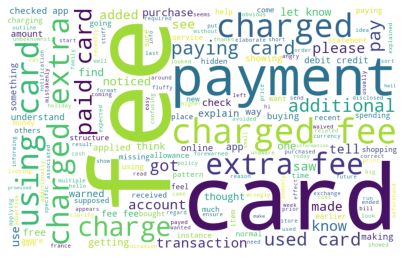

In [25]:
## word cloud for highest count for intent = 'card_payment_fee_charged'

intent_text = ""
for t in utterances[utterances['intent'] == 'card_payment_fee_charged']['lemmatized_utterance']:
    intent_text += t +" "
wordCloud = WordCloud(width=800, height=500, background_color='white').generate(intent_text)
plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.axis("Off")
plt.show()

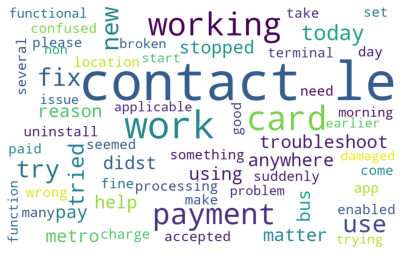

In [26]:
## word cloud for lowest count intent = 'contactless_not_working	'

intent_text = ""
for t in utterances[utterances['intent'] == 'contactless_not_working']['lemmatized_utterance']:
    intent_text += t +" "
wordCloud = WordCloud(width=800, height=500, background_color='white').generate(intent_text)
plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.axis("Off")
plt.show()

### Label Encode the class label i.e. 'intent' column

In [27]:
from sklearn import preprocessing

labelEncoding = preprocessing.LabelEncoder()
utterances['intent'] = labelEncoding.fit_transform(utterances['intent']) 
utterances.head()

,utterance,intent,cleaned_utterance,lemmatized_utterance
0,i am still waiting on my card,12,still waiting card,still waiting card
1,what can i do if my card still hasn't arrived ...,12,card still arrived weeks,card still arrived week
2,i have been waiting over a week is the card st...,12,waiting week card still coming,waiting week card still coming
3,can i track my card while it is in the process...,12,track card process delivery,track card process delivery
4,how do i know if i will get my card or if it i...,12,know get card lost,know get card lost


### Model Building and testing using MultiNomialNB using Count Vectorizer and tf-idf Vectorizer


In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

Model building using MultiNomialNB (Naive Bayes) Model and uni-gram CountVectorizer for Classification

In [45]:
"""
Now convert each message into a vector that machine learning models can understand.

"""
# Initialize uni-gram CountVectorizer
vectorizer = CountVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
count_vectorizer_unigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = count_vectorizer_unigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.8056844547563805
F1 score: [0.89285714 0.8358209  0.875      0.91304348 0.66666667 0.97777778
 0.73239437 0.88888889 0.8        0.9        0.91666667 0.
 0.84745763 0.53846154 0.80769231 0.62068966 0.725      0.80645161
 0.81818182 0.2        0.90909091 0.78571429 0.88888889 0.47619048
 0.66666667 0.78947368 0.65625    0.66666667 0.82926829 0.8
 0.75471698 0.95       0.89473684 0.68965517 0.92307692 0.81481481
 0.82352941 0.89361702 0.64285714 0.75       0.69767442 0.84848485
 0.47058824 0.95       0.47058824 0.97142857 0.87096774 0.90566038
 0.70833333 0.78571429 0.78947368 0.60869565 0.95081967 0.91525424
 0.8        0.94117647 0.91428571 0.85       0.97297297 0.62745098
 0.78571429 0.74074074 0.69230769 0.84931507 0.78688525 0.79069767
 0.78688525 0.71794872 0.61538462 0.72222222 0.91428571 0.93023256
 0.         0.95454545 0.69767442 0.92307692 0.85714286]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model building using MultiNomialNB (Naive Bayes) Model and bi-gram CountVectorizer for Classification

In [49]:
# bi-gram CountVectorizer using pipeline approach

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Creating a pipeline object
count_vector_MNB_pipeline = Pipeline([
    ('vectorizer_bigrams', CountVectorizer(ngram_range = (2, 2))), 
     ('Multi NB', MultinomialNB())         
])
 
# fit with features
count_vector_MNB_pipeline.fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = count_vector_MNB_pipeline.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="micro"))
print (classification_report(y_test, y_pred))

Accuracy: 0.7093967517401392
F1 score: 0.7093967517401392
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        29
           1       1.00      0.61      0.76        28
           2       1.00      0.89      0.94        18
           3       0.96      1.00      0.98        22
           4       1.00      0.14      0.25        14
           5       1.00      0.91      0.95        22
           6       0.57      0.77      0.66        30
           7       0.74      0.70      0.72        33
           8       0.69      0.41      0.51        27
           9       0.83      0.86      0.84        28
          10       0.67      0.82      0.73        22
          11       0.50      0.11      0.18         9
          12       0.55      0.78      0.65        27
          13       0.69      0.47      0.56        19
          14       0.87      0.83      0.85        24
          15       0.82      0.50      0.62        18
          16       0.19

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model building using MultiNomialNB (Naive Bayes) Model and uni-gram and bi-gram CountVectorizer for Classification

In [51]:
# uni-gram, bi-gram CountVectorizer
unibigram_vectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(unibigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_unibigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_unibigram_MNB_model.predict(X_test)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.8213457076566125
F1 score: [0.91803279 0.92857143 1.         0.95652174 0.52631579 0.9
 0.71052632 0.88571429 0.76923077 0.93333333 0.84615385 0.5
 0.84615385 0.625      0.88       0.84848485 0.7654321  0.69230769
 0.77142857 0.71428571 0.8358209  0.7037037  0.93023256 0.69565217
 0.66666667 0.9047619  0.78688525 0.725      0.80952381 0.86111111
 0.93023256 0.97674419 0.89473684 0.68965517 0.95       0.75471698
 0.73913043 0.88372093 0.70967742 0.83870968 0.75555556 0.84848485
 0.72727273 0.9047619  0.66666667 0.94117647 0.87719298 0.93877551
 0.74509804 0.76363636 0.9        0.72       0.91525424 0.89285714
 0.76595745 0.97142857 0.77419355 0.86486486 0.94444444 0.57692308
 0.9375     0.83333333 0.62068966 0.89855072 0.86153846 0.7804878
 0.76923077 0.72727273 0.75       0.68571429 0.97297297 0.82608696
 0.28571429 0.95652174 0.6875     0.83076923 0.81355932]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
      

Model building using MultiNomialNB (Naive Bayes) Model and uni-gram, bi-gram, tri-gram CountVectorizer for Classification

In [53]:
# uni-gram, bi-gram, tri-gram CountVectorizer

trigram_vectorizer = CountVectorizer(ngram_range=(1,3)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(trigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_trigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_trigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted"))
print (classification_report(y_test, y_pred))

Accuracy: 0.8190255220417634
F1 score: 0.8152841541538577
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.74      0.93      0.83        28
           2       1.00      0.83      0.91        18
           3       0.92      1.00      0.96        22
           4       1.00      0.64      0.78        14
           5       0.95      0.95      0.95        22
           6       0.59      0.73      0.66        30
           7       0.79      0.94      0.86        33
           8       0.91      0.78      0.84        27
           9       0.82      0.96      0.89        28
          10       0.58      1.00      0.73        22
          11       1.00      0.33      0.50         9
          12       0.92      0.81      0.86        27
          13       1.00      0.47      0.64        19
          14       0.92      0.92      0.92        24
          15       0.71      0.56      0.63        18
          16       0.67

Model building using MultiNomialNB (Naive Bayes) Model and trigram CountVectorizer for Classification

In [54]:
#tri-gram CountVectorizer

trigram_vectorizer = CountVectorizer(ngram_range=(3,3)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(trigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_trigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_trigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.4385150812064965
F1 score: [0.53658537 0.5        0.43478261 0.82051282 0.         0.48275862
 0.62068966 0.56521739 0.45       0.61904762 0.71794872 0.
 0.6        0.41666667 0.75       0.4        0.07727273 0.5
 0.72       0.         0.55319149 0.65306122 0.72727273 0.42105263
 0.5        0.38709677 0.53658537 0.42307692 0.42424242 0.78571429
 0.74285714 0.64516129 0.66666667 0.63414634 0.51851852 0.48780488
 0.48484848 0.37037037 0.75862069 0.27272727 0.46666667 0.82758621
 0.         0.53333333 0.16666667 0.66666667 0.70833333 0.58536585
 0.55555556 0.58536585 0.68965517 0.45454545 0.65384615 0.65116279
 0.52631579 0.56       0.46153846 0.75       0.53846154 0.35294118
 0.21052632 0.36842105 0.61538462 0.58333333 0.57777778 0.68965517
 0.31818182 0.57142857 0.28571429 0.4        0.84848485 0.76470588
 0.5        0.68571429 0.4        0.54901961 0.73684211]
              precision    recall  f1-score   support

           0       0.92      0.38      0.54        29
      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Model building using MultiNomialNB (Naive Bayes) Model and tf-idf (term frequency - inverse document frequency) vectorizer for Classification


In [ ]:
# Using TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
tfidfvectorizer_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = tfidfvectorizer_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Shape of X_train:  (6894, 1811)
Shape of X_test:  (1724, 1811)


In [ ]:
# tf-idf vectorizer and MNB model using Pipeline approach

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

# Creating a pipeline object
tfidf_vector_MNB_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])
 
 #fit with features
tfidf_vector_MNB_pipeline.fit(X_train, y_train)

#get the predictions for X_test using pipeline object
y_pred = tfidf_vector_MNB_pipeline.predict(X_test)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted"))
print (classification_report(y_test, y_pred))

Shape of X_train:  (6894,)
Shape of X_test:  (1724,)


Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('Multi NB', MultinomialNB())])

### Using KNN (K Nearest Neighbour) Model and CountVectorizer

##### Using ngram_range as unigram and bigram and metric as Euclidean distance.

In [65]:
# CountVectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
count_vector_KNN1_pipeline = Pipeline([
    ('vectorizer_count', CountVectorizer()),        #using the ngram_range parameter 
     ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'))         
])
 
 #fit with features
count_vector_KNN1_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = count_vector_KNN1_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.728538283062645
F1 score: 0.7316129137068555
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        29
           1       0.69      0.89      0.78        28
           2       0.84      0.89      0.86        18
           3       0.96      1.00      0.98        22
           4       0.50      0.86      0.63        14
           5       1.00      0.86      0.93        22
           6       0.43      0.74      0.54        31
           7       0.92      0.73      0.81        33
           8       0.84      0.59      0.70        27
           9       0.79      0.79      0.79        28
          10       1.00      0.77      0.87        22
          11       0.33      0.44      0.38         9
          12       0.56      0.85      0.68        27
          13       0.47      0.42      0.44        19
          14       1.00      0.75      0.86        24
          15       0.88      0.78      0.82        18
          16       0.78 

##### Using ngram_range as unigram, bigram and trigram and metric as cosine distance.

In [64]:
# CountVectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
count_vector_KNN2_pipeline = Pipeline([
    ('vectorizer_count', CountVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))         
])
 
 #fit with features
count_vector_KNN2_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = count_vector_KNN2_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.7865429234338747
F1 score: 0.7858298328668171
              precision    recall  f1-score   support

           0       0.88      0.79      0.84        29
           1       0.74      0.89      0.81        28
           2       0.95      1.00      0.97        18
           3       1.00      1.00      1.00        22
           4       0.72      0.93      0.81        14
           5       1.00      0.82      0.90        22
           6       0.56      0.80      0.66        30
           7       0.83      0.91      0.87        33
           8       0.91      0.78      0.84        27
           9       0.73      0.79      0.76        28
          10       0.94      0.77      0.85        22
          11       0.62      0.56      0.59         9
          12       0.57      0.74      0.65        27
          13       0.72      0.68      0.70        19
          14       0.95      0.79      0.86        24
          15       0.67      0.78      0.72        18
          16       0.87

### Using KNN (K Nearest Neighbour) Model and TF-IDF Vectorizer

#####Using Euclidean distance metric.

In [ ]:
# TF-IDF Vectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
tfidf_vector_KNN1_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean'))         
])
 
 #fit with features
tfidf_vector_KNN1_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = tfidf_vector_KNN1_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.7853828306264501
F1 score: 0.78157920791717
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.86      0.83      0.84        29
                                activate_my_card       1.00      0.93      0.96        28
                                       age_limit       1.00      1.00      1.00        18
                         apple_pay_or_google_pay       1.00      1.00      1.00        22
                                     atm_support       0.69      0.64      0.67        14
                                automatic_top_up       1.00      0.82      0.90        22
         balance_not_updated_after_bank_transfer       0.63      0.77      0.70        31
balance_not_updated_after_cheque_or_cash_deposit       0.89      0.94      0.91        33
                         beneficiary_not_allowed       0.78      0.67      0.72        27
                                 cancel_tra

#####Using Cosine distance metric.

In [ ]:
# TF-IDF Vectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
tfidf_vector_KNN2_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance', metric='cosine'))         
])
 
 #fit with features
tfidf_vector_KNN2_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = tfidf_vector_KNN2_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.7801624129930395
F1 score: 0.7708850336695414
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.86      0.83      0.84        29
                                activate_my_card       0.96      0.96      0.96        28
                                       age_limit       0.95      1.00      0.97        18
                         apple_pay_or_google_pay       1.00      0.95      0.98        22
                                     atm_support       0.83      0.71      0.77        14
                                automatic_top_up       1.00      1.00      1.00        22
         balance_not_updated_after_bank_transfer       0.71      0.77      0.74        31
balance_not_updated_after_cheque_or_cash_deposit       0.90      0.79      0.84        33
                         beneficiary_not_allowed       0.95      0.70      0.81        27
                                 cancel_t

### Using SVM (Support Vector Machine) Model and TF-IDF Vectorizer

##### Using TF-IDF Vectorizer

In [ ]:
# TF-IDF Vectorizer and SVM model 

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

SVM_classifier_model1 = SVC(kernel='linear', gamma='auto')

#fit with features
SVM_classifier_model1.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = SVM_classifier_model1.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted")) #Weighted F1 score since data is imbalanced.

print (classification_report(y_test, y_pred))


Accuracy: 0.8538283062645011
F1 score: 0.8554987274769833
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        29
           1       1.00      0.89      0.94        28
           2       0.95      1.00      0.97        18
           3       1.00      1.00      1.00        22
           4       1.00      0.64      0.78        14
           5       1.00      0.77      0.87        22
           6       0.66      0.77      0.71        30
           7       0.82      1.00      0.90        33
           8       0.81      0.81      0.81        27
           9       0.96      0.89      0.93        28
          10       1.00      0.95      0.98        22
          11       0.64      0.78      0.70         9
          12       0.57      0.78      0.66        27
          13       0.60      0.79      0.68        19
          14       0.96      0.92      0.94        24
          15       0.64      0.78      0.70        18
          16       0.76

##### Using Count Vectorizer

In [ ]:
# Count Vectorizer with unigram and bigram range and SVC model

count_vectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(count_vectorizer.todense())
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

SVM_classifier_mode2 = SVC(kernel='linear', gamma='auto')

#fit with features
SVM_classifier_mode2.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = SVM_classifier_mode2.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted")) #Weighted F1 score since data is imbalanced.

print (classification_report(y_test, y_pred))


Accuracy: 0.8074245939675174
F1 score: 0.8089832770932689
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        29
           1       0.92      0.86      0.89        28
           2       0.77      0.94      0.85        18
           3       1.00      1.00      1.00        22
           4       0.52      0.79      0.63        14
           5       1.00      0.86      0.93        22
           6       0.71      0.65      0.68        31
           7       0.88      0.88      0.88        33
           8       0.92      0.81      0.86        27
           9       1.00      0.79      0.88        28
          10       1.00      0.82      0.90        22
          11       0.62      0.89      0.73         9
          12       0.68      0.78      0.72        27
          13       0.67      0.63      0.65        19
          14       0.90      0.79      0.84        24
          15       0.71      0.83      0.77        18
          16       0.86

### Using RandomForest Classifier with TF-IDF Vectorizer and CountVectorizer

##### Using TF-IDF Vectorizer

In [31]:
# Using RandomForestClassifier and TF-IDF Vectorizer

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

randomForestClassifier1 = RandomForestClassifier()

#fit with features 
randomForestClassifier1.fit(X_train, y_train)

#get the predictions of X_test
y_pred = randomForestClassifier1.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

print (classification_report(y_test, y_pred))


Accuracy: 0.8283062645011601
F1 score: 0.820368696900244
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       1.00      0.90      0.95        29
           2       0.95      0.95      0.95        21
           3       0.95      1.00      0.97        18
           4       0.77      0.91      0.83        11
           5       0.90      1.00      0.95        19
           6       0.54      0.68      0.60        22
           7       0.81      0.92      0.86        38
           8       0.83      0.78      0.81        32
           9       0.86      0.96      0.91        26
          10       0.73      1.00      0.84        16
          11       0.80      0.73      0.76        11
          12       0.68      0.85      0.76        20
          13       0.93      0.61      0.74        23
          14       0.93      0.89      0.91        28
          15       0.83      0.83      0.83        18
          16       0.93 

##### Using Count Vectorizer

In [33]:
# Using RandomForestClassifier and Count Vectorizer 

countVectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(countVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

randomForestClassifier2 = RandomForestClassifier()

#fit with features 
randomForestClassifier2.fit(X_train, y_train)

#get the predictions of X_test
y_pred = randomForestClassifier2.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8114849187935035
F1 score: 0.8083794780908631
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.95      0.83      0.88        23
           2       0.85      1.00      0.92        17
           3       0.91      1.00      0.95        21
           4       0.53      0.73      0.62        11
           5       1.00      0.81      0.89        21
           6       0.68      0.85      0.75        27
           7       0.88      0.88      0.88        26
           8       0.83      0.93      0.88        27
           9       0.85      0.96      0.90        24
          10       1.00      0.90      0.95        21
          11       0.67      0.83      0.74        12
          12       0.58      0.88      0.70        24
          13       0.47      0.80      0.59        10
          14       0.90      0.86      0.88        21
          15       0.95      0.78      0.86        23
          16       0.77

### Using RandomOverSampler to balance the imbalanced data

#### Using SVM

In [38]:
# We will use TF-IDF Vectorizer with SVM Model (since SVM classifier above gives 
# highest accuracy so far) with RandomOverSampler to balance the data.


tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = tfidfVectorizer.toarray()

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Uncomment to see the distribution
#print("instances per class label in training data before oversampling.")
#display(Counter(y_train))

#Define RandomOverSampler 

randomOverSampler = RandomOverSampler(random_state=500)
X_train_ROS, y_train_ROS = randomOverSampler.fit_resample(X_train, y_train)

# Check the number of instanaces for each class in oversampled training data
#Uncomment to see the distribution
#print("instances per class label in training data after oversampling.")
#display(Counter(y_train_ROS))

SVM_classifier_model3 = SVC(kernel='linear', gamma='auto')

#fit with oversampled features 
SVM_classifier_model3.fit(X_train_ROS, y_train_ROS)

#get the predictions of X_test
y_pred = SVM_classifier_model3.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8549883990719258
F1 score: 0.8564098261907106
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        29
           1       0.93      0.96      0.95        28
           2       1.00      0.94      0.97        18
           3       1.00      1.00      1.00        22
           4       0.91      0.71      0.80        14
           5       1.00      0.91      0.95        22
           6       0.75      0.68      0.71        31
           7       0.89      0.94      0.91        33
           8       0.89      0.89      0.89        27
           9       0.86      0.89      0.88        28
          10       1.00      0.91      0.95        22
          11       0.62      0.89      0.73         9
          12       0.74      0.93      0.82        27
          13       0.71      0.79      0.75        19
          14       1.00      0.83      0.91        24
          15       0.62      0.72      0.67        18
          16       0.85

#### Using SMOTE to balance the imbalanced data

In [35]:
# We will use TF-IDF Vectorizer with SVM Model (since SVM classifier above gives 
# highest accuracy so far) with SMOTE to balance the data.

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Uncomment to see the distribution
#print("instances per class label in training data before oversampling.")
#display(Counter(y_train))

#Define SMOTE 

smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Check the number of instanaces for each class in oversampled training data
#Uncomment to see the distribution
#print("instances per class label in training data after oversampling.")
#display(Counter(y_train_SMOTE))

SVM_classifier_model4 = SVC(kernel='linear', gamma='auto')

#fit with oversampled features 
SVM_classifier_model4.fit(X_train_SMOTE, y_train_SMOTE)

#get the predictions of X_test
y_pred = SVM_classifier_model4.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8602088167053364
F1 score: 0.86088670761615
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       1.00      0.97      0.98        30
           2       0.94      1.00      0.97        16
           3       1.00      0.94      0.97        18
           4       0.93      0.72      0.81        18
           5       1.00      1.00      1.00        11
           6       0.74      0.76      0.75        34
           7       0.83      0.95      0.89        37
           8       0.84      0.90      0.87        29
           9       0.94      1.00      0.97        29
          10       1.00      0.94      0.97        18
          11       0.62      0.62      0.62        13
          12       0.79      0.86      0.83        22
          13       0.74      0.81      0.77        21
          14       1.00      0.94      0.97        18
          15       0.75      0.86      0.80        14
          16       0.86  

#### Using RandomForestClassifer and SMOTE

In [33]:
# Using RandomForestClassifier and TF-IDF Vectorizer with OverSampling technique SMOTE

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

randomForestClassifier3 = RandomForestClassifier()

#fit with oversampled features 
randomForestClassifier3.fit(X_train_SMOTE, y_train_SMOTE)

#get the predictions of X_test
y_pred = randomForestClassifier3.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8356535189481825
F1 score: 0.8317368892207276
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.86      0.84      0.85        43
           2       0.97      0.97      0.97        33
           3       1.00      1.00      1.00        31
           4       0.95      0.88      0.91        24
           5       1.00      0.92      0.96        39
           6       0.72      0.65      0.68        40
           7       0.81      0.95      0.87        40
           8       0.89      0.86      0.88        37
           9       0.88      0.86      0.87        44
          10       0.82      0.90      0.86        30
          11       0.50      0.80      0.62        10
          12       0.79      0.81      0.80        42
          13       0.62      0.78      0.69        23
          14       0.97      0.89      0.93        35
          15       0.61      0.79      0.69        24
          16       0.73

#### Using MultiNomialNB Classifier and SMOTE

In [58]:
# Using TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Initalize MNB classifier and fit with features
MNB_model_SMOTE = MultinomialNB().fit(X_train_SMOTE, y_train_SMOTE)

# get the predictions for X_test using pipeline object
y_pred = MNB_model_SMOTE.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.83584686774942
F1 score: [0.93103448 0.94736842 0.97142857 0.84       0.92307692 1.
 0.76190476 0.88235294 0.74418605 0.82539683 0.78431373 0.6
 0.66666667 0.73684211 0.85714286 0.72727273 0.89855072 0.78571429
 0.93333333 0.85714286 0.88235294 0.85714286 0.87804878 0.75862069
 0.71428571 0.72222222 0.8        0.83870968 0.66666667 0.84375
 0.87804878 1.         0.85       0.97297297 0.97435897 0.88135593
 0.69387755 0.87804878 0.8        0.82051282 0.71428571 0.8
 0.74074074 0.9047619  0.65       1.         0.88135593 0.82352941
 0.875      0.72340426 0.83333333 0.8        0.93333333 0.88888889
 0.76595745 0.88888889 0.85714286 0.80952381 0.84848485 0.75555556
 0.90322581 0.88       0.77777778 0.93548387 0.8        0.76595745
 0.78688525 0.73913043 0.91428571 0.66666667 0.82051282 0.95454545
 0.625      1.         0.74285714 0.87096774 0.77777778]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        29
           1      

#### Using K-fold CrossValidation set

### Using Gensim library for text classification

### Performing NER (Named Entity Recognition)

### Intent Classification Using Deep Learning Models